In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

^C


In [144]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pickle

In [145]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


**importing and exploring the dataset**

In [146]:
with open('german-traffic-signs/train.p', 'rb') as f :
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f :
  val_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f :
  test_data = pickle.load(f)

type(train_data)

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

In [147]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [148]:
import pandas as pd
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

array([[[197, 166, 123],
        [189, 154,  99],
        [198, 160, 102],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[170, 139,  97],
        [177, 144,  88],
        [185, 150,  94],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[165, 135,  96],
        [163, 132,  85],
        [169, 138,  88],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[119, 114,  79],
        [122, 115,  77],
        [131, 121,  86],
        ...,
        [ 84,  97, 105],
        [ 73,  85,  90],
        [ 71,  71,  73]],

       [[135, 116,  77],
        [131, 116,  73],
        [129, 117,  78],
        ...,
        [ 43,  53,  57],
        [ 39,  52,  56],
        [ 75,  77,  80]],

       [[154, 118,  80],
        [149, 124,  84],
        [136, 122,  84],
        ...,
        [ 41,  51,  41],
        [ 51,  68,  61],
        [ 79,  86,  82]]], dtype=uint8)
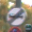

In [149]:
X_train[100]

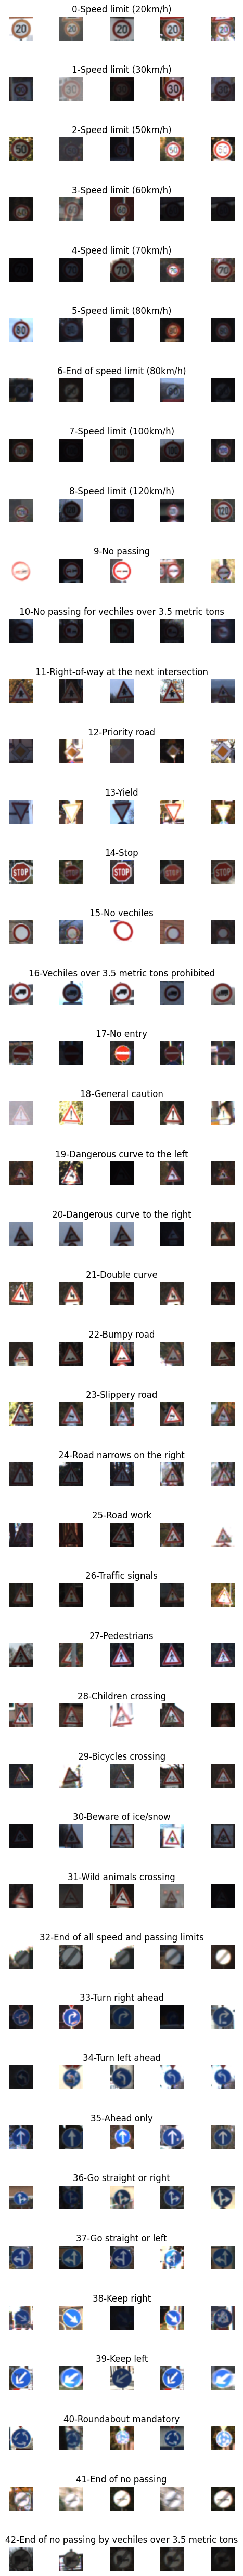

In [150]:
import random

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots( nrows = num_classes, ncols = cols, figsize=(5,50) )
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows() :
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), : , : ], cmap = plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i ==2 :
      axs[j][i].set_title(str(j) + "-" + row["SignName"] )
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


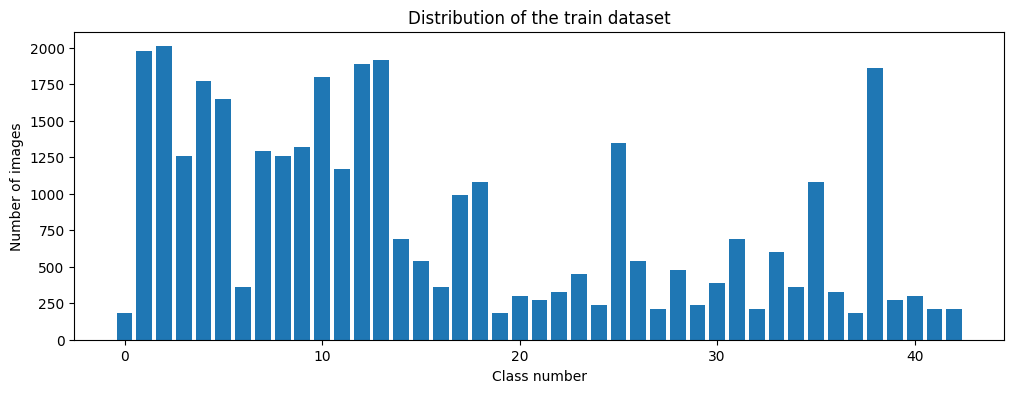

In [151]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

**Preprocessing**

(32, 32, 3)

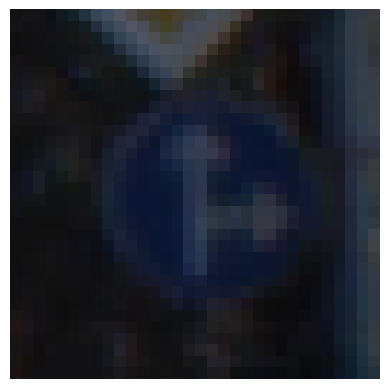

In [152]:
plt.imshow(X_train[1000])
plt.axis("off")
X_train[1000].shape

In [153]:
import cv2
def grayscale(img):
  newimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return newimg


In [154]:
def equalize(img):
  newimg = cv2.equalizeHist(img)
  return newimg


In [155]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array( list( map(preprocessing, X_train) ) )
X_test = np.array( list( map(preprocessing, X_test) ) )
X_val = np.array( list( map(preprocessing, X_val) ) )

(34799, 32, 32)

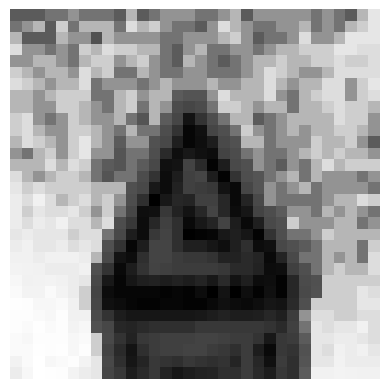

In [156]:
plt.imshow(X_train[random.randint(0,2000)], cmap='gray')
plt.axis("off")
X_train.shape

In [157]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [158]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator( width_shift_range=0.1 , height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
data_gen.fit(X_train)

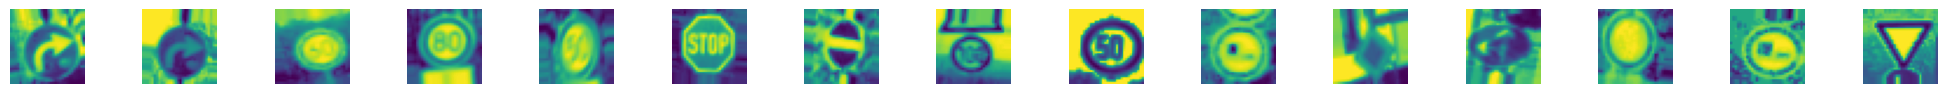

In [159]:
batches = data_gen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [160]:
y_train.shape

(34799,)

In [161]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

In [162]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [163]:
from keras.models import Sequential

def leNet_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [164]:
model = leNet_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 60)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 4, 4, 30)          0         
 ng2D)                                                

In [165]:
history = model.fit(data_gen.flow(X_train,y_train, batch_size=50), epochs=10, validation_data=(X_val,y_val), shuffle=1)

Epoch 1/10
696/696 [==============================] - 16s 21ms/step - loss: 2.0940 - accuracy: 0.4054 - val_loss: 0.4642 - val_accuracy: 0.8762
Epoch 2/10
696/696 [==============================] - 14s 21ms/step - loss: 0.8260 - accuracy: 0.7439 - val_loss: 0.1637 - val_accuracy: 0.9560
Epoch 3/10
696/696 [==============================] - 15s 21ms/step - loss: 0.5689 - accuracy: 0.8256 - val_loss: 0.1114 - val_accuracy: 0.9698
Epoch 4/10
696/696 [==============================] - 14s 20ms/step - loss: 0.4380 - accuracy: 0.8629 - val_loss: 0.0856 - val_accuracy: 0.9746
Epoch 5/10
696/696 [==============================] - 14s 21ms/step - loss: 0.3737 - accuracy: 0.8847 - val_loss: 0.0825 - val_accuracy: 0.9728
Epoch 6/10
696/696 [==============================] - 15s 21ms/step - loss: 0.3299 - accuracy: 0.8977 - val_loss: 0.0560 - val_accuracy: 0.9846
Epoch 7/10
696/696 [==============================] - 15s 21ms/step - loss: 0.2994 - accuracy: 0.9060 - val_loss: 0.0587 - val_accuracy:

Text(0.5, 0, 'epoch ')

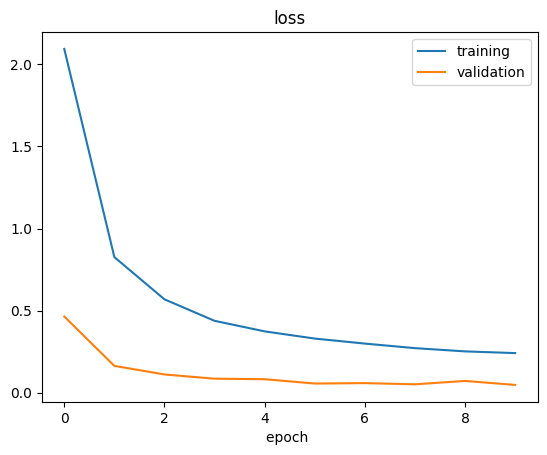

In [166]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch ')

In [167]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epoch ')

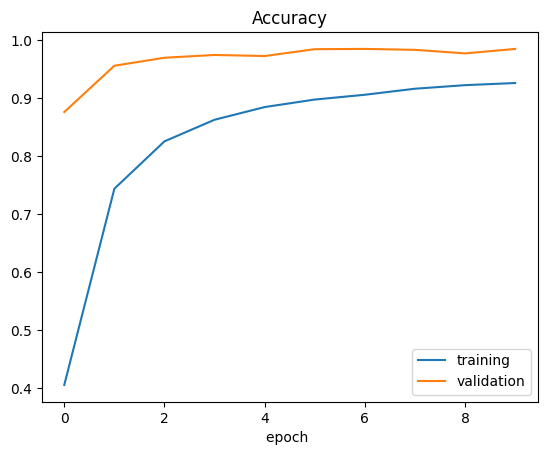

In [168]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch ')

In [169]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test Score', score[0])
print('Test Accuracy', score[1])

Test Score 0.1270827203989029
Test Accuracy 0.9653206467628479


Testing on real images

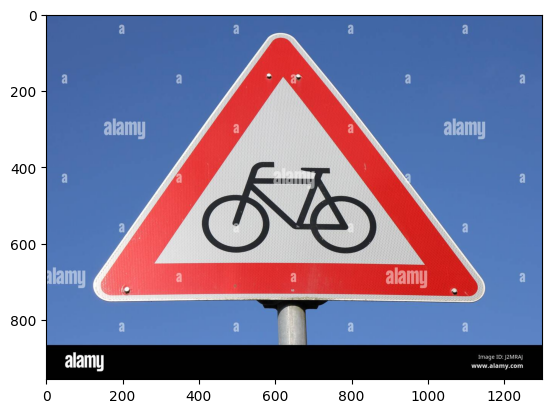

In [170]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'

r = requests.get(url , stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap = plt.get_cmap('gray'))

(32, 32)


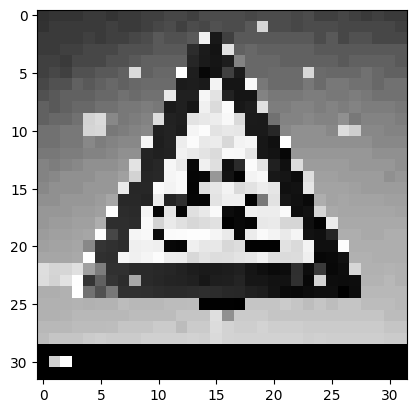

In [171]:
img = np.asarray(img)
img = cv2.resize(img, (32,32))
img = preprocessing(img)
plt.imshow(img, cmap= plt.get_cmap('gray'))
print(img.shape)

In [172]:
img = img.reshape(1,32,32,1)
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=-1)
print("The predicted sign is : " + str(predicted_class))

1/1 [==============================] - 0s 114ms/step
The predicted sign is : [29]
